In [16]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [17]:
import numpy as np

def density_Gaussian(mean_vec,covariance_mat,x_set):
    """ Return the density of multivariate Gaussian distribution
        Inputs: 
            mean_vec is a 1D array (like array([,,,]))
            covariance_mat is a 2D array (like array([[,],[,]]))
            x_set is a 2D array, each row is a sample
        Output:
            a 1D array, probability density evaluated at the samples in x_set.
    """
    d = x_set.shape[1]  
    inv_Sigma = np.linalg.inv(covariance_mat)
    det_Sigma = np.linalg.det(covariance_mat)
    density = []
    for x in x_set:
        x_minus_mu = x - mean_vec
        exponent = - 0.5*np.dot(np.dot(x_minus_mu,inv_Sigma),x_minus_mu.T)
        prob = 1/(((2*np.pi) ** (d/2))*np.sqrt(det_Sigma))*np.exp(exponent)
        density.append(prob)
    density_array = np.array(density)  
    
    return density_array 

def get_data_in_file(filename):
    """ 
    Read the input/traget data from the given file as arrays 
    """
    with open(filename, 'r') as f:
        data = []
        # read the data line by line
        for line in f: 
            data.append([float(x) for x in line.split()]) 
            
    # store the inputs in x and the tragets in z      
    data_array = np.array(data)     
    x = data_array[:,0:1]   # 2D array
    z = data_array[:,1:2]   # 2D array
    
    return (x, z)




In [25]:
def plot_a(title, xlabel, ylabel, contour, A0, A1, fignum):
    plt.figure(fignum)
    plt.plot([-0.1], [-0.5], marker='o', color='r')
    plt.contour(A0, A1, contour, colors='b')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

In [19]:
def plot_b(title, xlabel, ylabel, x_train, z_train, x, mu_prime, std_dev, fignum):
    plt.figure(fignum)
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.scatter(x_train, z_train, color='b')
    plt.errorbar(x, mu_prime, yerr=std_dev, fmt='ro')
    plt.title(title)

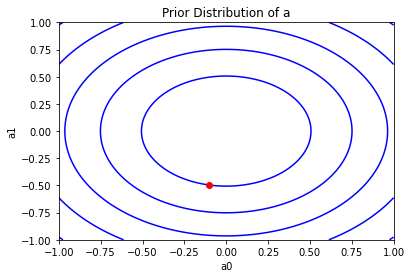

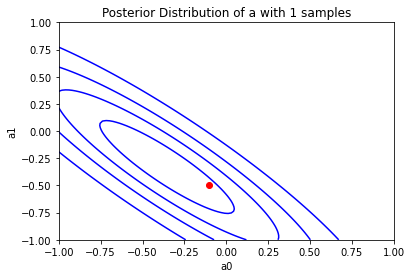

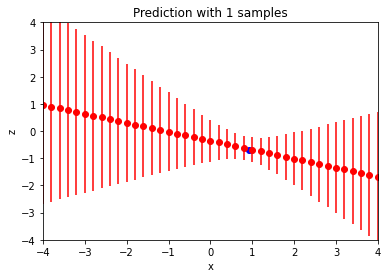

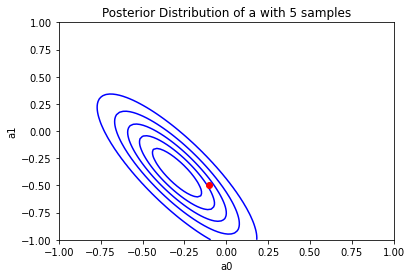

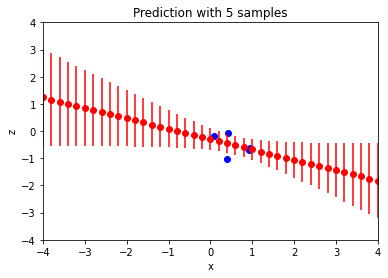

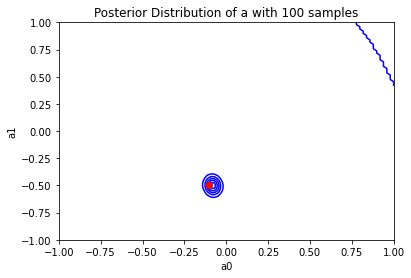

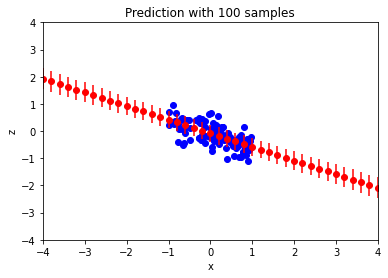

In [27]:
import matplotlib.pyplot as plt

def priorDistribution(beta, fignum):
    """
    Plot the contours of the prior distribution p(a)
    
    Inputs:
    ------
    beta: hyperparameter in the proir distribution
    
    Outputs: None
    -----
    """
    ### TODO: Write your code here
    a0 = a1 = np.linspace(-1, 1, 100)
    A0, A1 = np.meshgrid(a0, a1)
    a0 = A0[0].reshape(100, 1)
    contour = []
    mu = [0, 0]
    cov = [[beta, 0], [0, beta]]
    for i in range(0, 100):
        x = np.concatenate((a0, A1[i].reshape(100, 1)), 1)
        contour.append(density_Gaussian(mu, cov, x))

    plot_a('Prior Distribution of a', 'a0', 'a1', contour, A0, A1, fignum)
    
    return 
    
def posteriorDistribution(x,z,beta,sigma2,fignum):
    """
    Plot the contours of the posterior distribution p(a|x,z)
    
    Inputs:
    ------
    x: inputs from training set
    z: targets from traninng set
    beta: hyperparameter in the proir distribution
    sigma2: variance of Gaussian noise
    
    Outputs: 
    -----
    mu: mean of the posterior distribution p(a|x,z)
    Cov: covariance of the posterior distribution p(a|x,z)
    """
    ### TODO: Write your code here
    a = x
    cov_a_inv = [[1/beta, 0], [0, 1/beta]]
    cov_w = sigma2
    A = np.append(np.ones(shape=(len(x), 1)), x, axis=1)

    Cov = np.linalg.inv(cov_a_inv + np.dot(A.T, np.dot(1/cov_w, A)))
    mu = np.dot(Cov, (np.dot(np.dot(A.T, 1/cov_w), z)))
    mu = mu.reshape(2,1).squeeze()

    a0 = a1 = np.linspace(-1, 1, 100)
    A0, A1 = np.meshgrid(a0, a1)
    a0 = A0[0].reshape(100, 1)
    contour = []

    for i in range(0, 100):
        x = np.concatenate((a0, A1[i].reshape(100, 1)), 1)
        contour.append(density_Gaussian(mu, Cov, x))

    plot_a('Posterior Distribution of a with %a samples' %len(a), 'a0', 'a1', contour, A0, A1, fignum)

    return (mu, Cov)

def predictionDistribution(x,beta,sigma2,mu,Cov,x_train,z_train,fignum):
    """
    Make predictions for the inputs in x, and plot the predicted results 
    
    Inputs:
    ------
    x: new inputs
    beta: hyperparameter in the proir distribution
    sigma2: variance of Gaussian noise
    mu: output of posteriorDistribution()
    Cov: output of posteriorDistribution()
    x_train,z_train: training samples, used for scatter plot
    
    Outputs: None
    -----
    """
    ### TODO: Write your code here
    a = x_train
    A = np.append(np.ones(shape=(len(x), 1)), np.expand_dims(x, 1), axis=1)
    mu_prime = np.dot(A, mu)
    cov_prime = sigma2 + np.dot(A, np.dot(Cov, A.T))
    std_dev = np.sqrt(np.diag(cov_prime))

    plot_b('Prediction with %a samples' %len(a), 'x', 'z', x_train, z_train, x, mu_prime, std_dev, fignum)


    
    return 

if __name__ == '__main__':
    
    # training data
    x_train, z_train = get_data_in_file('/content/gdrive/My Drive/ECE368/training.txt')
    # new inputs for prediction 
    x_test = [x for x in np.arange(-4,4.01,0.2)]
    
    # known parameters 
    sigma2 = 0.1
    beta = 1

    #figure 1
    fignum = 1
    # prior distribution p(a)
    priorDistribution(beta, fignum)
    
    # number of training samples used to compute posterior
    ns  = [1, 5, 100]
    
    for i in range(3):
        # used samples
        x = x_train[0:ns[i]]
        z = z_train[0:ns[i]]
        
        #figures 2, 3, 4
        fignum = fignum + 1
        # posterior distribution p(a|x,z)
        mu, Cov = posteriorDistribution(x,z,beta,sigma2,fignum)
        
        #figures 5, 6, 7
        fignum = fignum + 3
        # distribution of the prediction
        predictionDistribution(x_test,beta,sigma2,mu,Cov,x,z,fignum)

        fignum = fignum - 3

    plt.show()
    

   

    
    
    

    
